# E10 뉴스 기사 요약하기

## 1. 데이터 수집하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow==1.15.0

  Using cached tensorflow-1.15.0-cp37-cp37m-manylinux2010_x86_64.whl (412.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.15.0 which is incompatible.


In [3]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [4]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [6]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [7]:
data.sample(10)

,headlines,text
71358,Shilpa announces game show as her first TV pro...,Actress Shilpa Shetty has announced the live g...
86102,"Pakistan not an ally, but a threat: US think tank",Accusing Pakistan of providing a breeding grou...
72279,Ahmedabad gets World Heritage City certificate,Nearly two months after declaring Gujarat's Ah...
98035,BBC interview kid needs to be Earth's Presiden...,Reacting to a press conference attended by fou...
89671,"Muslims who join RSS, BJP to be beaten: Shahi ...",Shahi Imam of Kolkata's Tipu Sultan mosque Mau...
82460,Woman cop who confronted BJP mob part of UP's ...,"A female senior police officer, who had confro..."
70207,India defeated Pakistan 3-0 in the teams' firs...,India and Pakistan played their first-ever T20...
10515,"Centre, Maha govt form panels to probe tigress...",The Centre and the Maharashtra government have...
65700,Woman hurt after Elphinstone stationÃ¢ÂÂs ce...,A 38-year-old woman suffered head injuries on ...
82278,Leopard's dead body found atop a 12-foot pole ...,The dead body of a leopard was found on top of...


## 2. 데이터 전처리하기 (추상적 요약)

In [8]:
#중복 유무
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [9]:
data.drop_duplicates(subset = ['headlines'], inplace=True)
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


In [10]:
#null 값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [11]:
#불용어제거
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [12]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
#전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어 함수를 호출
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [15]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

35.662832260131836  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

In [16]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


훈련에 사용할 샘플의 최대길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299444342675704


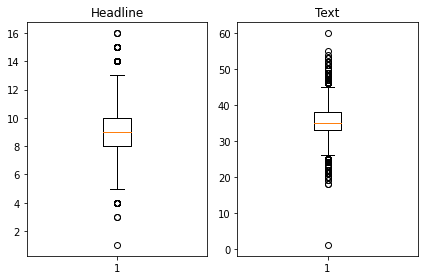

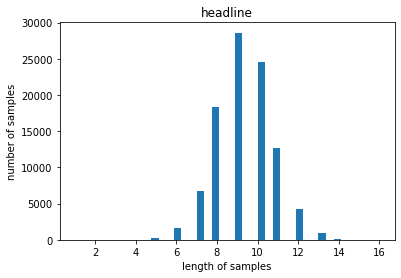

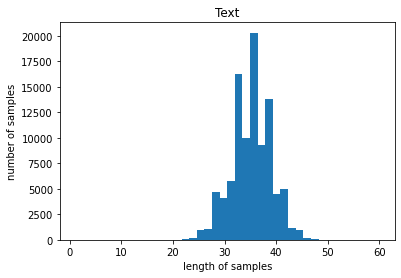

In [19]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headline_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headline_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('Headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
text_max_len = 40
headlines_max_len = 11

In [21]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [22]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.92383627444994
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9450041725183692


In [23]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85756


시작 토큰과 종료 토큰 추가하기

In [24]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [25]:
#인코더의 입력과 디코더의 입력을 numpy 타입으로 변경
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

훈련 데이터와 텍스트 데이터 분리
- train:test = 8:2

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[30874 26696 14820 ... 28719 30143 27701]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17151


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))


훈련 데이터의 개수 : 68605
훈련 레이블의 개수 : 68605
테스트 데이터의 개수 : 17151
테스트 레이블의 개수 : 17151


단어집합 (vocabulary) 만들기 : Tokenization

- Tokenizer()
: 텍스트를 토큰화

- fit_on_texts()
: 입력 데이터로부터 단어 집합 생성, 각 단어에 고유한 정수가 부여

- word_index
: 생성된 단어 집합

- word_counts
: 각 단어와 그 단어의 등장 빈도수가 저장되어있는 딕셔너리

- texts_to_sequences()
: 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다.

In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [31]:
#빈도수가 낮은 단어들 제거
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64656
등장 빈도가 6번 이하인 희귀 단어의 수: 44078
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20578
단어 집합에서 희귀 단어의 비율: 68.17310071764415
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.778223292131693


In [32]:
#단어 집합에서 희귀 단어를 제외시킬 경우 단어집합의 크기는 20589
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 정수로 잘 변경되었는지 샘플 출력
print(encoder_input_train[:3])

[[2389, 15450, 576, 84, 481, 576, 647, 534, 1774, 84, 7374, 6228, 7375, 15451, 85, 488, 88, 625, 871, 605, 3064, 89, 23], [1506, 649, 4254, 124, 262, 709, 1080, 626, 564, 4183, 406, 1827, 1804, 17107, 2967, 515, 1384, 11, 6301, 1027, 865, 14742, 2986, 2588, 92, 515, 331, 7507, 1738, 2318, 435, 322, 664], [25, 388, 1302, 14142, 14142, 18048, 1374, 146, 3480, 146, 546, 12219, 10325, 7903, 12664, 159, 3327, 8492, 51, 388, 2589, 627, 5788, 15452, 13, 226, 8667, 4754, 51, 33, 226, 1536, 3027, 4474, 6865, 198, 387]]


In [34]:
# Summary 데이터에 동일 작업 진행, 훈련 데이터로 부터 단어 집합 만들기
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28436
등장 빈도가 5번 이하인 희귀 단어의 수: 18746
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9690
단어 집합에서 희귀 단어의 비율: 65.92347728231819
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.21412722798722


In [36]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2664, 5927, 456], [1, 664, 307, 97, 1899, 7064, 3, 189, 457], [1, 38, 350, 13, 848, 1993, 5928, 5407, 5670, 7065, 52], [1, 22, 731, 73, 5, 1994, 11, 918, 3981], [1, 189, 763, 7066, 17, 1597, 1498, 182, 4, 203]]
target
decoder  [[2664, 5927, 456, 2], [664, 307, 97, 1899, 7064, 3, 189, 457, 2], [38, 350, 13, 848, 1993, 5928, 5407, 5670, 7065, 52, 2], [22, 731, 73, 5, 1994, 11, 918, 3981, 2], [189, 763, 7066, 17, 1597, 1498, 182, 4, 203, 2]]


요약문 길이가 1인 경우, 해당 샘플은 삭제

In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68605
훈련 레이블의 개수 : 68605
테스트 데이터의 개수 : 17151
테스트 레이블의 개수 : 17151


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


패딩하기

In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [40]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [41]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [42]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [43]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [46]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=10)

Train on 68605 samples, validate on 17151 samples
Epoch 1/10
68605/68605 [==============================] - 333s 5ms/sample - loss: 4.2450 - val_loss: 4.2767
Epoch 2/10
68605/68605 [==============================] - 328s 5ms/sample - loss: 4.1043 - val_loss: 4.2001
Epoch 3/10
68605/68605 [==============================] - 327s 5ms/sample - loss: 4.0023 - val_loss: 4.1413
Epoch 4/10
68605/68605 [==============================] - 328s 5ms/sample - loss: 3.9130 - val_loss: 4.0875
Epoch 5/10
68605/68605 [==============================] - 329s 5ms/sample - loss: 3.8325 - val_loss: 4.0369
Epoch 6/10
68605/68605 [==============================] - 327s 5ms/sample - loss: 3.7562 - val_loss: 4.0003
Epoch 7/10
68605/68605 [==============================] - 329s 5ms/sample - loss: 3.6881 - val_loss: 3.9643
Epoch 8/10
68605/68605 [==============================] - 329s 5ms/sample - loss: 3.6270 - val_loss: 3.9344
Epoch 9/10
68605/68605 [==============================] - 328s 5ms/sample - loss: 3.56

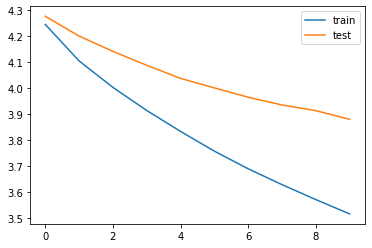

In [47]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

인퍼런스 모델 구현

In [48]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [49]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [50]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [51]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [52]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [53]:
for i in range(3):
    print(i+1, "-------------------------------------------------------")
    print("원문 :", seq2text(encoder_input_test[i]))
    print("\n")
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

1 -------------------------------------------------------
원문 : four time tripura chief minister manik sarkar sunday submitted resignation governor bjp win state assembly elections adding governor asked continue new chief minister decided said continue till thank people years 


실제 요약 : four time tripura cm sarkar submits resignation 
예측 요약 :  tripura cm announces resignation of bjp


2 -------------------------------------------------------
원문 : actress addressing dating rumours co star manish said years younger father scope romantic involvement people even suggested tie rakhi convince everyone added said cannot let rumours affect equation 


실제 요약 : no for involvement on dating manish 
예측 요약 :  was not my father for my life says neha


3 -------------------------------------------------------
원문 : indian captain virat kohli scored th odi century thursday third list centuries odi history kohli also became fastest odi centuries reaching landmark th innings completed century th quickest 

## 5. Summa을 이용해서 추출적 요약해보기

In [54]:
!pip install summa

     |████████████████████████████████| 54 kB 2.2 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54410 sha256=85578f52e14e25fd52bf8236173fc0455d220b941fee32c2d3beacf08ea27b62
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [55]:
import requests
from summa.summarizer import summarize

In [56]:
text= pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
text["text"][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [60]:
for i in range(3):
    print(i+1, "-------------------------------------------------------")
    print("원문 :", data['text'][i])
    print("\n")
    print("실제 요약 :", data['headlines'][i])
    print("추출적 요약 :", summarize(text["text"][i], ratio=0.5))
    print("\n")

실제 HEADLINE :  upgrad learner switches to career in ml al with salary hike
추출적 요약 HEADLINE :  




KeyError: ignored

## 6. 회고